Produce the visibility plot from the data and show the frank fit

In [2]:
import os, sys, time
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from matplotlib.colorbar import Colorbar
import matplotlib.colors as mcolors
from matplotlib.patches import Ellipse
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter,
                               AutoMinorLocator)
from astropy.io import fits
from astropy.visualization import (AsinhStretch, LinearStretch, ImageNormalize)

import frank
from frank.radial_fitters import FrankFitter
from frank.geometry import FixedGeometry
from frank.utilities import convolve_profile, sweep_profile
from frank.io import save_fit, load_sol
from frank.make_figs import make_full_fig
from gofish import imagecube  # for the CLEAN profile
sys.path.append('../frank_fit')
import diskdictionary as disk

In [3]:
target = 'AA_Tau'
target_label = disk.disk[target]['label']

In [4]:
# Load data
dat_uv = np.load(f'../data/{target}_continuum.vis.npz')
u, v, vis, weights = dat_uv['u'], dat_uv['v'], dat_uv['Vis'], dat_uv['Wgt']

# Load frank fit
sol = load_sol(f'../frank_fit/fits/{target}_frank_sol.obj')
r_frank = sol.r
Inu_frank = sol.I

In [5]:
u_deproj, v_deproj, vis_deproj = sol.geometry.apply_correction(u, v, vis)
baselines = (u_deproj**2 + v_deproj**2)**.5
bin_width = 15e3
binned_vis = frank.utilities.UVDataBinner(baselines, vis_deproj, weights, bin_width)

vis_re_kl = binned_vis.V.real * 1e3
vis_im_kl = binned_vis.V.imag * 1e3
vis_err_re_kl = binned_vis.error.real * 1e3
vis_err_im_kl = binned_vis.error.imag * 1e3
vis_fit = sol.predict_deprojected(binned_vis.uv).real * 1e3

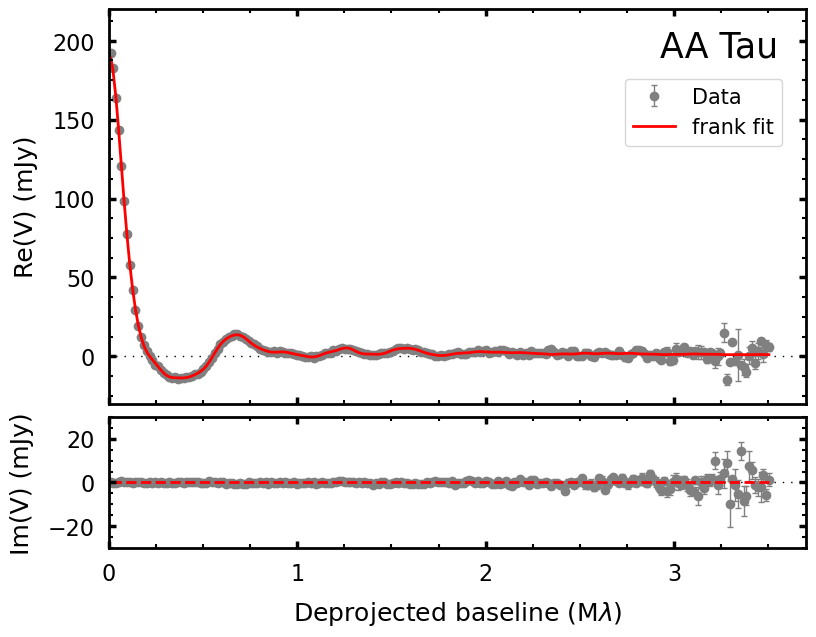

In [6]:
#Plot data
fig, axs = plt.subplots(2,1,figsize=(9,7), gridspec_kw={'height_ratios': [3, 1]})
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0, hspace=0.05)

#axs[0].scatter(binned_vis.uv / 1e6, vis_re_kl, s=50, color='grey', alpha=1.0, marker='o', zorder=1, label='Data')
axs[0].errorbar(binned_vis.uv / 1e6, vis_re_kl, vis_err_re_kl, color='grey',fmt='o', alpha=1.0, capsize=2, linewidth=1, zorder=1, label='Data')
axs[0].plot(binned_vis.uv / 1e6, vis_fit, color='r', linewidth=2, zorder=1.5, label='frank fit')
axs[0].text(0.96, 0.88, target_label, ha='right', transform=axs[0].transAxes, fontsize=25)

axs[1].errorbar(binned_vis.uv / 1e6, vis_im_kl, vis_err_im_kl, color='grey', fmt='o', alpha=1.0, capsize=2, linewidth=1, zorder=1)
axs[1].plot(binned_vis.uv / 1e6, np.zeros(binned_vis.uv.shape[0]), color='r', linestyle='dashed', zorder=1.5, linewidth=2)

axs[0].hlines(0,-10,10, alpha=1, linestyle=(0,(1,5)), color='k', linewidth=1, zorder=0)
axs[1].hlines(0,-10,10, alpha=1, linestyle=(0,(1,5)), color='k', linewidth=1, zorder=0)

axs[0].set_xlim(0,3.7)
axs[1].set_xlim(0,3.7)
axs[0].set_ylim(-30,220)
axs[1].set_ylim(-30,30)

index_xticks = 1
axs[0].xaxis.set_major_locator(MultipleLocator(index_xticks))
axs[0].xaxis.set_minor_locator(MultipleLocator(index_xticks/4))
axs[1].xaxis.set_major_locator(MultipleLocator(index_xticks))
axs[1].xaxis.set_minor_locator(MultipleLocator(index_xticks/4))

index_yticks_Re = 50
axs[0].yaxis.set_major_locator(MultipleLocator(index_yticks_Re))
axs[0].yaxis.set_minor_locator(MultipleLocator(index_yticks_Re/4))

index_yticks_Im = 20
axs[1].yaxis.set_major_locator(MultipleLocator(index_yticks_Im))
axs[1].yaxis.set_minor_locator(MultipleLocator(index_yticks_Im/4))

axs[0].tick_params(which='major',axis='both',right=True,top=True, labelsize=16, pad=10,width=2.5, length=5,direction='in',color='k')
axs[0].tick_params(which='minor',axis='both',right=True,top=True, labelsize=16, pad=10,width=1.5, length=3,direction='in',color='k')

axs[1].tick_params(which='major',axis='both',right=True,top=True, labelsize=16, pad=10,width=2.5, length=5,direction='in',color='k')
axs[1].tick_params(which='minor',axis='both',right=True,top=True, labelsize=16, pad=10,width=1.5, length=3,direction='in',color='k')

axs[0].set_xlabel(r'Deprojected baseline (M$\lambda$)', fontsize = 18, labelpad=10)
axs[0].set_ylabel('Re(V) (mJy)', fontsize = 18, labelpad=10)

axs[1].set_xlabel(r'Deprojected baseline (M$\lambda$)', fontsize = 18, labelpad=10)
axs[1].set_ylabel('Im(V) (mJy)', fontsize = 18, labelpad=10)

handles, labels = axs[0].get_legend_handles_labels()
order = [1, 0]  # frank fit second (index 0), Data first (index 1)
axs[0].legend([handles[idx] for idx in order],[labels[idx] for idx in order],
              bbox_to_anchor=[0.98, 0.85], fontsize=15)

# Hide x labels and tick labels for top plots and y ticks for right plots.
for ax in axs.flat:
    ax.label_outer()
 
for axis in ['top', 'bottom', 'left', 'right']:
    axs[0].spines[axis].set_linewidth(2)    
    axs[1].spines[axis].set_linewidth(2)  
    
plt.savefig(f'{target}_vis_frank_fit.pdf', bbox_inches='tight')

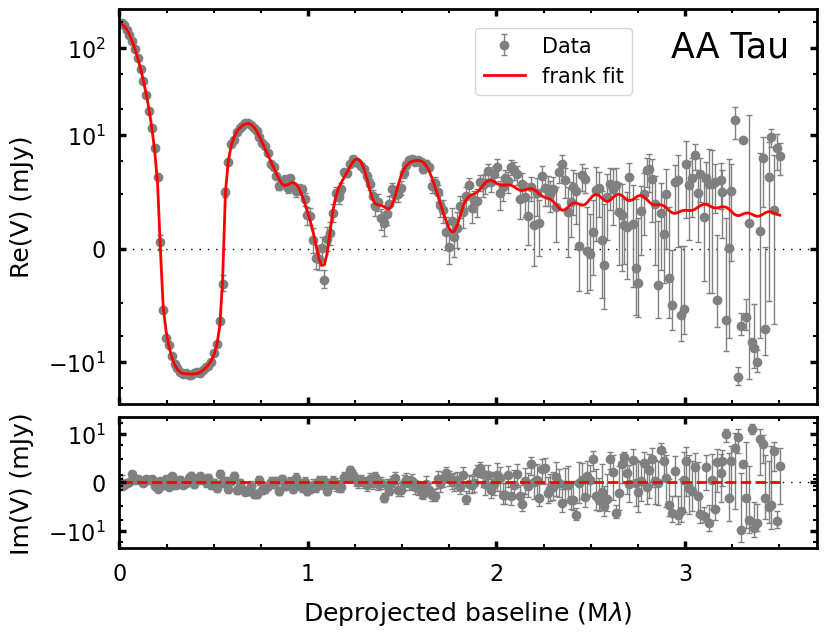

In [7]:
#Plot data
fig, axs = plt.subplots(2,1,figsize=(9,7), gridspec_kw={'height_ratios': [3, 1]})
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0, hspace=0.05)

#axs[0].scatter(binned_vis.uv / 1e6, vis_re_kl, s=50, color='grey', alpha=1.0, marker='o', zorder=1, label='Data')
axs[0].errorbar(binned_vis.uv / 1e6, vis_re_kl, vis_err_re_kl, color='grey',fmt='o', alpha=1.0, capsize=2, linewidth=1, zorder=1, label='Data')
axs[0].plot(binned_vis.uv / 1e6, vis_fit, color='r', linewidth=2, zorder=1.5, label='frank fit')
axs[0].text(0.96, 0.88, target_label, ha='right', transform=axs[0].transAxes, fontsize=25)

axs[1].errorbar(binned_vis.uv / 1e6, vis_im_kl, vis_err_im_kl, color='grey', fmt='o', alpha=1.0, capsize=2, linewidth=1, zorder=1)
axs[1].plot(binned_vis.uv / 1e6, np.zeros(binned_vis.uv.shape[0]), color='r', linestyle='dashed', zorder=1.5, linewidth=2)

axs[0].hlines(0,-10,10, alpha=1, linestyle=(0,(1,5)), color='k', linewidth=1, zorder=0)
axs[1].hlines(0,-10,10, alpha=1, linestyle=(0,(1,5)), color='k', linewidth=1, zorder=0)

axs[0].set_xlim(0,3.7)
axs[1].set_xlim(0,3.7)
axs[0].set_ylim(-30,280)
axs[1].set_ylim(-30,30)

index_xticks = 1
axs[0].xaxis.set_major_locator(MultipleLocator(index_xticks))
axs[0].xaxis.set_minor_locator(MultipleLocator(index_xticks/4))
axs[1].xaxis.set_major_locator(MultipleLocator(index_xticks))
axs[1].xaxis.set_minor_locator(MultipleLocator(index_xticks/4))

index_yticks_Re = 50
axs[0].yaxis.set_major_locator(MultipleLocator(index_yticks_Re))
axs[0].yaxis.set_minor_locator(MultipleLocator(index_yticks_Re/4))

index_yticks_Im = 20
axs[1].yaxis.set_major_locator(MultipleLocator(index_yticks_Im))
axs[1].yaxis.set_minor_locator(MultipleLocator(index_yticks_Im/4))

axs[0].tick_params(which='major',axis='both',right=True,top=True, labelsize=16, pad=10,width=2.5, length=5,direction='in',color='k')
axs[0].tick_params(which='minor',axis='both',right=True,top=True, labelsize=16, pad=10,width=1.5, length=3,direction='in',color='k')

axs[1].tick_params(which='major',axis='both',right=True,top=True, labelsize=16, pad=10,width=2.5, length=5,direction='in',color='k')
axs[1].tick_params(which='minor',axis='both',right=True,top=True, labelsize=16, pad=10,width=1.5, length=3,direction='in',color='k')

axs[0].set_xlabel(r'Deprojected baseline (M$\lambda$)', fontsize = 18, labelpad=10)
axs[0].set_ylabel('Re(V) (mJy)', fontsize = 18, labelpad=10)

axs[1].set_xlabel(r'Deprojected baseline (M$\lambda$)', fontsize = 18, labelpad=10)
axs[1].set_ylabel('Im(V) (mJy)', fontsize = 18, labelpad=10)

axs[0].set_yscale('asinh')
axs[0].set_yticks([-10,0,10, 100])

axs[1].set_yscale('asinh')
axs[1].set_yticks([-10,0,10])

handles, labels = axs[0].get_legend_handles_labels()
order = [1, 0]  # frank fit second (index 0), Data first (index 1)
axs[0].legend([handles[idx] for idx in order],[labels[idx] for idx in order],
              bbox_to_anchor=[0.75, 0.98], fontsize=15)

# Hide x labels and tick labels for top plots and y ticks for right plots.
for ax in axs.flat:
    ax.label_outer()
 
for axis in ['top', 'bottom', 'left', 'right']:
    axs[0].spines[axis].set_linewidth(2)    
    axs[1].spines[axis].set_linewidth(2)  